In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
train_data = pd.read_csv('C:\\Users\\ajayr\\Deep Learning\\MNIST digits\\digit-recognizer\\train.csv')
test_data = pd.read_csv('C:\\Users\\ajayr\\Deep Learning\\MNIST digits\\digit-recognizer\\test.csv')


In [7]:
train_y = train_data['label'].to_numpy()
train_x = train_data.drop(columns=['label']).to_numpy()
test_data = test_data.to_numpy()

In [8]:
print("train_x:",train_x.shape,"\ntrain_y:", train_y.shape,"\ntest", test_data.shape)
print("number of training examples: ",train_x.shape[0])
print("number of test examples: ",test_data.shape[0])
print("dimensions of each image is: ",28,"x",28)



train_x: (42000, 784) 
train_y: (42000,) 
test (28000, 784)
number of training examples:  42000
number of test examples:  28000
dimensions of each image is:  28 x 28


In [12]:
train_y

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

In [14]:
def show_image(x):
    image = x.reshape(28,28)
    plt.imshow(image,cmap='gray')
    plt.show()

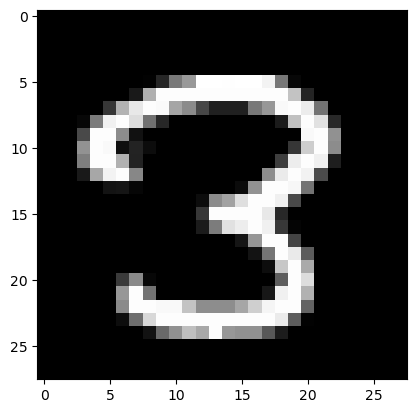

In [16]:
show_image(train_x[568])

We are going to construct a network with 1 hidden layer.
input layer nodes: 784 for each px
hidden layer nodes: 10
output layer nodes: 10 for each digit from 0 to 9

equations: 
    z1 = w1x1 + b1
    a1 = relu(z1)
    z2 = w2a1+b2
    a2 = softmax(z2)

Getting the dimensions right:
    we have 28*28 = 764 px, and 42000 images.

    x1: (784, 42000)
    w1: (10, 764)
    b1: (10,1) --> will be broadcasted
    z1, a1: (10, 42000)
    w2: (10,10)
    b2: (10,1) --> will be broadcasted
    z2, b2, a2: (10, 42000)
    


In [19]:
train_x = train_x.T
train_x = train_x / 255.0
test_data = test_data / 255.0


In [21]:
train_x.shape

(784, 42000)

In [23]:
train_y.shape # needs to be one hot encoded

(42000,)

In [25]:
train_y_one_hot = np.zeros((10,len(train_y)))
train_y_one_hot[train_y,np.arange(len(train_y))] = 1
print(train_y_one_hot.shape)



(10, 42000)


Helper functions and their uses:

1) layer_sizes -> input, hidden and output layer sizes
2) initialize_parameters -> w1, b1, w2, b2 as a dict
3) forward_prop -> return A2, cache : z1,a2,z2,a2
4) compute_cost -> return cost
5) backward_prop -> (use gradient equations) return grads: dict
6) update_params -> return updated params dict
7) nn_model -> initialize params, forward , cost, backward, update, after all iterations, return parameters
8) predict -> use the learned parameters, forward prop with the test data


In [36]:
train_y_one_hot.shape

(10, 42000)

In [38]:
def layer_sizes(X,Y):
    #given the X and Y, it gives out the n_x, n_h, n_y
    n_x = train_x.shape[0]
    n_h = 10
    n_y = train_y_one_hot.shape[0]

    return (n_x, n_h, n_y)
    

In [40]:
(n_x, n_h, n_y) = layer_sizes(train_x, train_y_one_hot)
print("n_x: ",n_x)
print("n_h: ",n_h)
print("n_y: ",n_y)

n_x:  784
n_h:  10
n_y:  10


In [42]:
def initialize_parameters(X,Y):
    #given the sizes of the layers, we can initialize the parameters
    (n_x, n_h, n_y) = layer_sizes(X, Y)
    # w1.shape = (n_h,n_x), w2.shape(n_y,n_h) -> random number 
    # b1.shape = (n_h,1), b2.shape(n_y,1) -> zeros
    w1= np.random.randn(n_h,n_x) * np.sqrt(2. /n_x)
    b1= np.zeros((n_h,1))
    w2= np.random.randn(n_y,n_h) * np.sqrt(2. /n_h)
    b2= np.zeros((n_y,1))

    paramters = {
        'w1':w1,
        'b1':b1,
        'w2':w2,
        'b2':b2
    }
    return paramters
    

In [44]:
def ReLU(z):
    a = np.maximum(0,z)
    assert a.shape == z.shape, "shape of z and a must be the same"
    return a
    

In [46]:
def softmax(z):
    # axis = 0 -> column
    t = np.exp(z - np.max(z, axis=0, keepdims=True))
    denominator = np.sum(t,axis=0,keepdims = True)
    a = np.divide(t,denominator,where=(denominator != 0))
    return a

In [48]:
def forward_prop(X,parameters):
    # return z1, a1, z2, a2
    w1=  parameters['w1']
    w2= parameters['w2']
    b1= parameters['b1']
    b2= parameters['b2']
    z1 = np.dot(w1,X) + b1
    a1 = ReLU(z1)
    z2 = np.dot(w2,a1)+ b2
    a2 = softmax(z2)

    cache = {
        'z1':z1,
        'z2':z2,
        'a1':a1,
        'a2':a2
    }

    return a2, cache

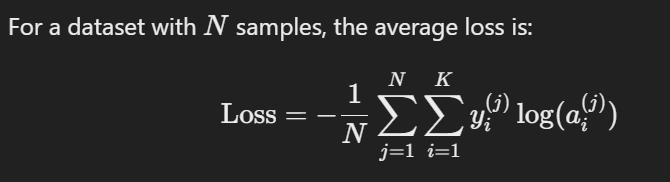

In [51]:
def compute_cost(Y,A):
    #cost for a multi-class classifications is defined as above
    m = Y.shape[1] 
    epsilon = 1e-10
    cost = -1/m * np.sum(Y * np.log(A + epsilon))
    cost = float(np.squeeze(cost))
    
    return cost
    
    

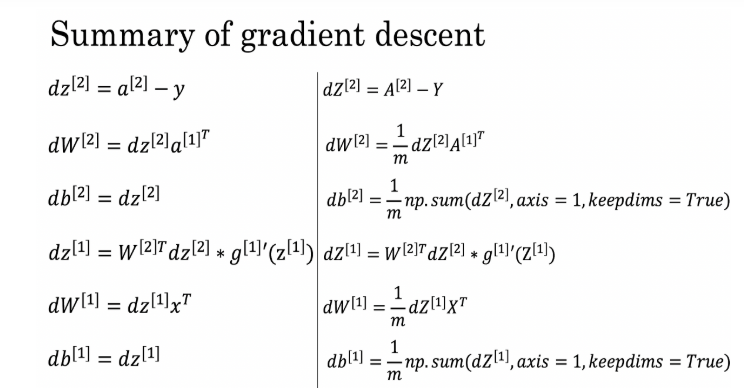

In [54]:
def ReLU_d(Z):
    return np.where(Z>0,1,0)
    

In [56]:
def backward_prop(X,Y,cache, parameters):
    #return dw2, dw1, db2, db1
    m =  X.shape[1]
    
    w1 = parameters['w1']
    w2 = parameters['w2']

    a1 = cache['a1']
    a2 = cache['a2']
    z1 = cache['z1']

    dz2 = a2 - Y
    dw2 = np.dot(dz2, a1.T) /m
    db2 = np.sum(dz2, axis=1, keepdims= True) /m
    dz1 = np.dot(w2.T,dz2) * (ReLU_d(z1))
    dw1 = np.dot(dz1,X.T)/m
    db1 = np.sum(dz1,axis = 1, keepdims = True)/m

    grads = {
        'dw2': dw2,
        'dw1': dw1,
        'db2': db2,
        'db1':db1
    }
    return grads
    
    
    
    

In [58]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    w1 = parameters['w1']
    w2 = parameters['w2']
    b1 = parameters['b1']
    b2 = parameters['b2']

    dw1 = grads['dw1']
    dw2 = grads['dw2']
    db1 = grads['db1']
    db2 = grads['db2']

    w1= w1 - learning_rate * dw1
    b1 = b1 - learning_rate * db1
    w2 = w2 - learning_rate * dw2
    b2 = b2 - learning_rate * db2

    paramters = {
        'w1':w1,
        'b1':b1,
        'w2':w2,
        'b2':b2
    }
    return paramters
    
    
    

In [60]:
def nn_model(X,Y,learning_rate = 1.2,n_iterations = 10000):
    parameters = initialize_parameters(X,Y)
    k = 1
    for i in range(n_iterations):
        a2,cache =  forward_prop(X,parameters)
        cost = compute_cost(Y,a2)
        grads=backward_prop(X,Y,cache,parameters)
        parameters = update_parameters(parameters, grads,learning_rate)

        if(k%1000 ==0 or k==1):
            print(f"iteration {k}:", cost)
        k+=1
    return parameters

        
    

In [62]:
parameters = nn_model(train_x, train_y_one_hot,learning_rate = 0.2)

iteration 1: 2.3686100455529497
iteration 1000: 0.2504296098118046
iteration 2000: 0.21895441827503212
iteration 3000: 0.20156185334189697
iteration 4000: 0.18921345201244535
iteration 5000: 0.17970898224239493
iteration 6000: 0.17230961677788234
iteration 7000: 0.1673046993160048
iteration 8000: 0.16291481242060818
iteration 9000: 0.15842405496321196
iteration 10000: 0.15435678377063242


In [63]:
def predict(parameters , X):
    a2,cache = forward_prop(X,parameters)
    
    predictions = np.argmax(a2,axis = 0)
    return predictions
    

(784, 28000)

In [68]:
test_image = test_data[678, :]  # Correctly selecting a single test sample.
test_image = test_image.reshape(-1, 1)  # Reshape for the model.
predicted_class = predict(parameters, test_image)
print(f"Predicted class: {predicted_class}")

Predicted class: [6]


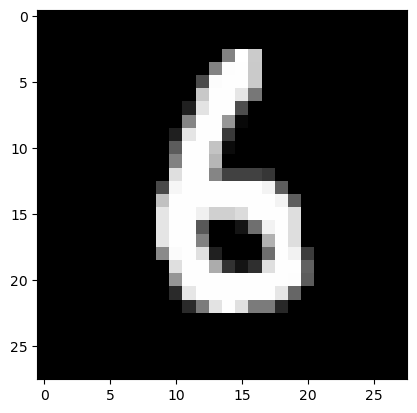

In [70]:
show_image(test_data[678,:])